In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
flatui = ["#9b59b6", "#2ecc71","#3498db", "#95a5a6", "#e74c3c", "#34495e"]
sns.set_palette(flatui)
import matplotlib.pyplot as plt
import os,sys,glob,json


In [2]:
import ipywidgets
from ipywidgets import interact
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

In [3]:
def get_chunk(mm,start,end,channels,sampling_rate=30000,remove_offset=True):
    chunk = mm[int(start*sampling_rate*int(channels)):int(np.floor(end*sampling_rate*(int(channels))))]
    chunk = np.reshape(chunk,(int(channels),-1),order='F')  * 0.195
    #print np.shape(chunk)
    if remove_offset:
        for i in np.arange(channels):
            chunk[i,:] = chunk[i,:] - np.mean(chunk[i,:])
    return chunk

def get_duration(mm,channels,sampling_rate=30000.):
    chunk=np.reshape(mm,(int(channels),-1),order='F')
    return chunk.shape[1]/float(sampling_rate)

def get_spike(spks_path,times,number_channels,pre=0.015,post=0.025,sampling_rate=30000):
    mm = np.memmap(spks_path, dtype=np.int16, mode='r')
    average = np.zeros((number_channels,int(sampling_rate*(pre+post))))
    count=0
    for time in times:
        try:
            temp = traces.get_chunk(mm,time-pre,time+post,number_channels,sampling_rate=sampling_rate)
            average += temp
            count+=1
        except:
            pass
    temp = temp/float(count)
    spikes_average = np.array(average.T - np.mean(average,1).T).T
    del(mm)

def get_lfp(lfp_path,times,number_channels,pre=0.015,post=0.025,sampling_rate=2500):
    mm = np.memmap(lfp_path, dtype=np.int16, mode='r')
    average = np.zeros((number_channels,int(sampling_rate*(pre+post))))
    count=0
    for time in sub_times:
        try:
            temp = traces.get_chunk(mm,time-pre,time+post,number_channels,sampling_rate=sampling_rate)
            average += temp
            count+=1
        except:
            pass
    temp = temp/float(count)
    lfp_average = np.array(average.T - np.mean(average,1).T).T
    del(mm)

def make_range_slider(data,start,window,num_channels=384,channels = [10],sampling_rate=2500,y_spacing=500,CAR=False):
    fig,ax=plt.subplots(figsize=(20,5))
    chunk = get_chunk(data,start,start+window,num_channels,sampling_rate=2500)
    if CAR:
        chunk_CAR = np.mean(chunk, axis=0)
    x = np.linspace(int(start),(start+window),int(window*sampling_rate))
    for i,ch in enumerate(channels):
        chunkch = chunk[ch,:]
        offset = np.mean(chunkch)
        if CAR: chunkch = chunkch - chunk_CAR
        ax.plot(x[:-1],np.diff(chunkch-offset+i*y_spacing),'k',lw=.5)

def cross_from_below(x, threshold):
    """
    return the indices into *x* where *x* crosses some threshold from below.
    """
    x = np.asarray(x)
    ind = np.nonzero((x[:-1] < threshold) & (x[1:] >= threshold))[0]
    if len(ind):
        return ind+1
    else:
        return ind

TODO: move these to dlab, continuous_traces.py

## Load data; parse the paths to find the different Neuropixels probes that we have

In [4]:
data_path = os.path.join(r'C:\Users\denma\Desktop\stim\2020-03-07_22-42-02_stim')

In [5]:
json.load(open(glob.glob(os.path.join(data_path,'events','*.json'))[0]))

{'error': {'code': 119}, 'success': False}

In [6]:
probe_names = []
for path in glob.glob(os.path.join(data_path,'events','*')):
    if os.path.isdir(path):
        probe_names.extend([path.split('-')[-1]]) 
slot_name = '-'.join(path.split('\\')[-1].split('-')[:3])

## Load the events and check them out

In [7]:
events = {}
states = {}
for probe in probe_names:
    events[probe] = np.load(os.path.join(data_path,'events',slot_name+'-'+probe,'TTL_1','event_timestamps.npy'))/30000.
    states[probe] = np.load(os.path.join(data_path,'events',slot_name+'-'+probe,'TTL_1','channel_states.npy'))

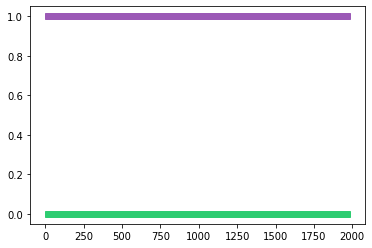

In [8]:
plt.plot(events['probe2'],np.ones(len(events['probe2'])),'|')
plt.plot(events['probe3'],np.zeros(len(events['probe2'])),'|')
# plt.xlim(0,3020)

## align probes to another

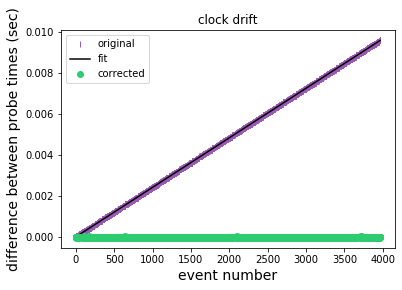

In [9]:
plt.plot(np.arange(len(events['probe3'])),events['probe2'] - events['probe3'],'|',label='original')
plt.xlabel('event number',fontsize=14)
plt.ylabel('difference between probe times (sec)',fontsize=14)
plt.title('clock drift')

fit = np.polyfit(np.arange(len(events['probe3'])), events['probe2'] - events['probe3'], 1)
p = np.poly1d(fit)
plt.plot(p(np.arange(len(events['probe3']))),'k',label='fit')

events['probe3_aligned'] = events['probe3'] + p(np.arange(len(events['probe3'])))
events['probe3_a2'] = events['probe3'] + (events['probe2'] - events['probe3'])
events['probe2_aligned'] = events['probe2'] 
plt.plot(np.arange(len(events['probe3'])),events['probe2_aligned'] - events['probe3_aligned'],'o',label='corrected')
plt.legend()

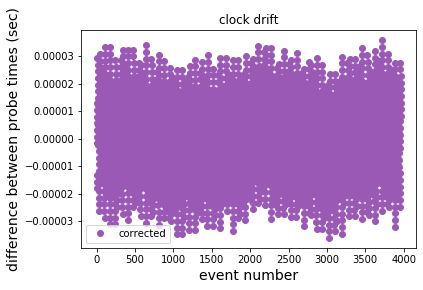

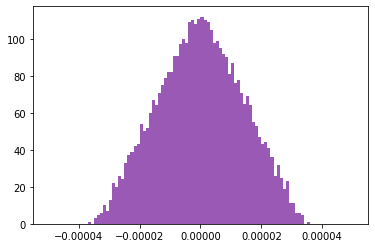

In [10]:
plt.xlabel('event number',fontsize=14)
plt.ylabel('difference between probe times (sec)',fontsize=14)
plt.title('clock drift')

plt.plot(np.arange(len(events['probe3'])),events['probe2_aligned'] - events['probe3_aligned'],'o',label='corrected')
plt.legend()

plt.figure()
d=plt.hist(events['probe2_aligned'] - events['probe3_aligned'],range=(-0.00005,0.00005),bins=100)

#### the linear correction aligned the events to <40 microseconds of each other. this is approximately one sample at 30kHz (33microseconds)

## load the lfp data

In [13]:
mm_lfp_2  = np.memmap(os.path.join(data_path,'continuous',slot_name+'-'+probe_names[0]+'-LFP','continuous.dat'), dtype=np.int16, mode='r')
mm_lfp_3  = np.memmap(os.path.join(data_path,'continuous',slot_name+'-'+probe_names[1]+'-LFP','continuous.dat'), dtype=np.int16, mode='r')

#### make an interactive plot to browse thought the data
find a range (in seconds) where there were some stims

interactive(children=(FloatSlider(value=400.0, description='start', max=800.0), FloatSlider(value=10.0, descri…

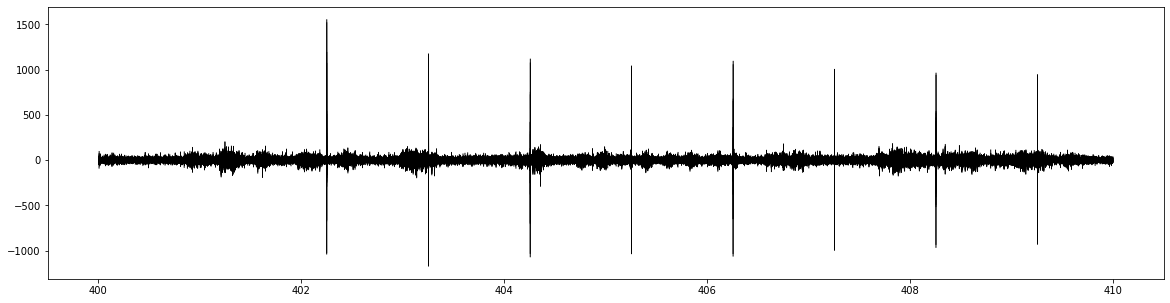

In [230]:
@interact()
def plot(start=(0,800,0.1),window=(0,20,0.1)):
    make_range_slider(mm_lfp_2,start,window,channels=np.arange(10),CAR=True)

293 - 326 seconds has some stims. don't know what these are, have to look in the log file which is on the C: drive in lab

## find the exact times of stimulation, by finding artifacts across channels

In [91]:

def find_events(data,start,window,num_channels=384,channels = [10],sampling_rate=2500,y_spacing=500):
    fig,ax=plt.subplots(figsize=(20,5))
    chunk = get_chunk(data,start,start+window,num_channels,sampling_rate=2500)
    chunk2=np.zeros(np.shape(chunk))
    chunk2=chunk
    chunk_CAR = np.mean(chunk, axis=0)
    x = np.linspace(int(start),(start+window),int(window*sampling_rate))
    for i,ch in enumerate(channels):
        chunkch = chunk[ch,:]
        offset = np.mean(chunkch)
        chunk2[i,:-1]=np.diff(chunkch - chunk_CAR - offset)
        crossings = cross_from_below(np.diff(chunkch - chunk_CAR - offset),700)
        ax.plot(np.array(crossings)/sampling_rate+start,np.ones(len(crossings))*i*y_spacing-offset+500,'o')
#         ax.plot(x,chunkch-offset+i*y_spacing,'k',lw=.5)

interactive(children=(FloatSlider(value=400.0, description='start', max=800.0), FloatSlider(value=10.0, descri…

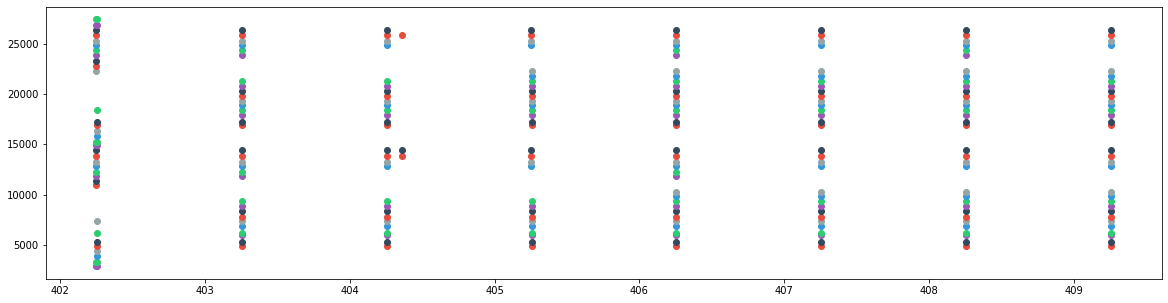

In [92]:
@interact()
def plot(start=(0,800,0.1),window=(0,20,0.1)):
    find_events(mm_lfp_2,start,window,channels=range(50))

In [231]:

def return_events_(data,start,window,num_channels=384,channels = [10],min_events=5,sampling_rate=2500,y_spacing=500):
    fig,ax=plt.subplots(figsize=(20,5))
    chunk = get_chunk(data,start,start+window,num_channels,sampling_rate=2500)
    chunk2=np.zeros(np.shape(chunk))
    chunk2=chunk
    chunk_CAR = np.mean(chunk, axis=0)
    x = np.linspace(int(start),(start+window),int(window*sampling_rate))
    all_=[]
    for i,ch in enumerate(channels):
        chunkch = chunk[ch,:]
        offset = np.mean(chunkch)
        chunk2[i,:-1]=np.diff(chunkch - chunk_CAR - offset)
        crossings = cross_from_below(np.diff(chunkch - chunk_CAR - offset),700)/sampling_rate+start
        all_.extend(crossings)
        ax.plot(crossings,np.ones(len(crossings))*i*y_spacing-offset+500,'o')
#         ax.plot(x,chunkch-offset+i*y_spacing,'k',lw=.5)
    x,t,dump=plt.hist(all_,bins=1000)
    rough_times = t[np.argwhere(x > min_events)].flatten()
    all_times = np.sort(np.array(all_).flatten())
    exact_times = np.ones(len(rough_times))
    for i in range(len(rough_times)-1):
        exact_times[i] = np.mean(all_times[np.where((all_times > rough_times[i]-0.0001)&(all_times < rough_times[i+1]))[0]])
    exact_times[-1] =  np.mean(all_times[np.where(all_times > rough_times[-1]-0.0001)])
#     fig1,ax1=plt.subplots(figsize=(20,5))
    plt.plot(exact_times, np.zeros(len(exact_times)),'o',ms=10)
    return exact_times

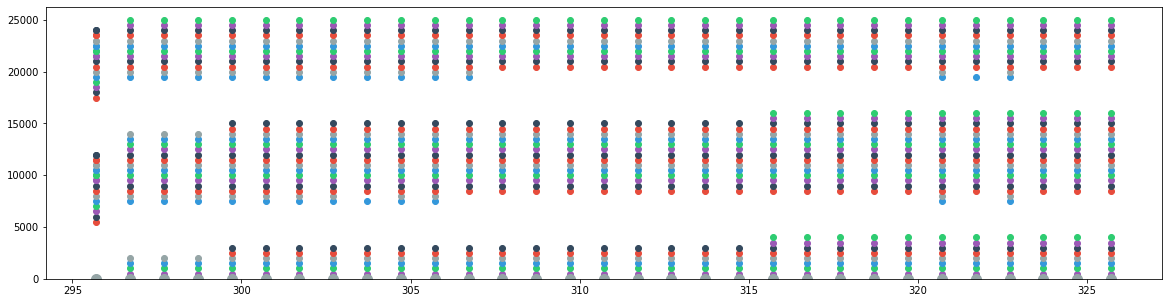

In [232]:
exact = return_events_(mm_lfp_2,293,34,channels=range(50))

In [233]:
exact

array([295.71084   , 296.71413333, 297.71413333, 298.71413333,
       299.71416471, 300.71416471, 301.71416471, 302.71416471,
       303.7141697 , 304.71416471, 305.71416471, 306.714175  ,
       307.71418667, 308.71418667, 309.71418667, 310.71418667,
       311.71418667, 312.71418667, 313.71418667, 314.71418667,
       315.71421176, 316.71421176, 317.71421176, 318.71421176,
       319.71421176, 320.71418947, 321.71420571, 322.71418947,
       323.71421176, 324.71421176, 325.71421176])

## make plots of averaged evoked LFP

In [182]:
window    = 0.3  # in seconds
fs        = 2500 # in Hz
num_channels = 384 

In [209]:
def triggered_avg(data,triggers,window,fs,num_channels):
    avg_LFP = np.zeros((num_channels,int(window*fs)))
    for start in exact:
        chunk = get_chunk(data,start,start+window,num_channels,sampling_rate=fs)
        
        chunk = chunk - np.mean(chunk, axis=0) # CAR
        
        avg_LFP += chunk
    avg_LFP = avg_LFP/len(exact)
    return avg_LFP

In [226]:
exact

array([295.71084   , 296.71413333, 297.71413333, 298.71413333,
       299.71416471, 300.71416471, 301.71416471, 302.71416471,
       303.7141697 , 304.71416471, 305.71416471, 306.714175  ,
       307.71418667, 308.71418667, 309.71418667, 310.71418667,
       311.71418667, 312.71418667, 313.71418667, 314.71418667,
       315.71421176, 316.71421176, 317.71421176, 318.71421176,
       319.71421176, 320.71418947, 321.71420571, 322.71418947,
       323.71421176, 324.71421176, 325.71421176])

In [225]:
exact + p(np.arange(len(exact)))

array([295.71085324, 296.71414899, 297.71415141, 298.71415382,
       299.71418761, 300.71419003, 301.71419244, 302.71419486,
       303.71420226, 304.71419969, 305.7142021 , 306.71421481,
       307.71422889, 308.71423131, 309.71423372, 310.71423614,
       311.71423855, 312.71424097, 313.71424338, 314.7142458 ,
       315.71427331, 316.71427573, 317.71427814, 318.71428056,
       319.71428297, 320.7142631 , 321.71428175, 322.71426793,
       323.71429263, 324.71429505, 325.71429746])

In [227]:
avg_2=triggered_avg(mm_lfp_2,exact-0.1,window,fs,num_channels)
avg_3=triggered_avg(mm_lfp_3,exact + p(np.arange(len(exact)))-0.1,window,fs,num_channels) # correct times for probe 3, since they were calculated from probe 2

(0, 384)

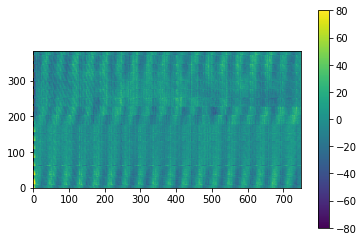

In [228]:
plt.imshow(avg_2,clim=(-80,80))
plt.colorbar()
plt.ylim(0,384)

(0, 384)

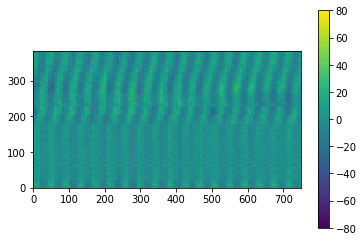

In [223]:
plt.imshow(avg_3,clim=(-80,80))
plt.colorbar()
plt.ylim(0,384)

## make plots of averaged evoked spikes

#### load the spikes data

In [234]:
mm_spikes_2  = np.memmap(os.path.join(data_path,'continuous',slot_name+'-'+probe_names[0]+'-AP','continuous.dat'), dtype=np.int16, mode='r')
# mm_lfp_3  = np.memmap(os.path.join(data_path,'continuous',slot_name+'-'+probe_names[1]+'-LFP','continuous.dat'), dtype=np.int16, mode='r')

In [4]:
avg_2_spikes =triggered_avg(mm_spikes_2,exact-0.1,window=window,fs=30000,num_channels=num_channels)


NameError: name 'triggered_avg' is not defined

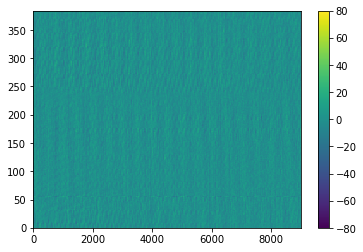

In [243]:
# plt.figure(figsize=(2,10))
plt.imshow(avg_2_spikes,clim=(-80,80))
plt.colorbar()
plt.ylim(0,384)
plt.gca().set_aspect(19)